In [1]:
from sklearn.metrics import f1_score , precision_score , recall_score , accuracy_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# data = pd.read_csv('data_test/M1-15+DemographicFeatureEng.csv', delimiter = ',').reset_index(drop=True)
# y_ans_data = pd.read_csv('data_test/M16All.csv', delimiter = ',') .drop(['B', 'C'], axis=1) 
# data = pd.read_csv('google_data/GGtrainnnnnnnnnnnnnnnnnnn.csv', delimiter = ',').reset_index(drop=True)
data = pd.read_csv('google_data/trainFeiFeiFin.csv', delimiter = ',').reset_index(drop=True)
data.shape

C:\Users\EBM_IT_01\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(521976, 29)

In [2]:
# list(data)

In [3]:
category_list = [
    'Mode_channelGrouping',
'Mode_device.deviceCategory',
 'Mode_device.isMobile',
 'Mode_geoNetwork.continent',
 'Mode_geoNetwork.subContinent',
    'Mode_Month',
 'Mode_browser2',
 'Mode_OperatSys2',
 'Mode_city2',
 'Mode_Country2',
 'Mode_metro2',
 'Mode_Domain2',
 'Mode_region2',
 'Mode_campaign',
 'Mode_TrueFalse',
 'Mode_Keyword',
 'Mode_SurceMed',
 'Mode_SourceSource',
]

In [4]:
# for i in category_list:
#     print(len(data[i].unique()),i)

In [5]:
data_ans = pd.read_csv('google_data/ForYourSubmissionIsus.csv', delimiter = ',')
data_ans.shape

C:\Users\EBM_IT_01\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(617242, 28)

In [6]:
data[category_list] = data[category_list].fillna('none')
data_ans[category_list] = data_ans[category_list].fillna('none')
data = data.fillna(0)
data_ans = data_ans.fillna(0)
data[['Mode_device.isMobile','Mode_TrueFalse']] = data[['Mode_device.isMobile','Mode_TrueFalse']].astype('str')
data_ans[['Mode_device.isMobile','Mode_TrueFalse']] = data_ans[['Mode_device.isMobile','Mode_TrueFalse']].astype('str')

In [7]:
data_x = data.drop(['Target','fullVisitorId'], axis=1)
x = data_x
feature_name = list(data_x)
y = data['Target'].values
# y = np.log(y+1)
# y.max()

In [8]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=0, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [9]:
x_ans = data_ans[feature_name]

In [10]:
df_combine=pd.concat([x,x_ans],ignore_index=True)
print(df_combine.shape)
#Find One_hot features that unique count <15
one_hot = df_combine[list(category_list)].nunique().reset_index()
one_hot.columns = ['features','unique_count']
one_hot = one_hot.loc[one_hot['unique_count'] < 10,"features"]
one_hot = list(one_hot)
one_hot

(1139218, 27)


['Mode_channelGrouping',
 'Mode_device.deviceCategory',
 'Mode_device.isMobile',
 'Mode_geoNetwork.continent',
 'Mode_OperatSys2',
 'Mode_campaign',
 'Mode_TrueFalse',
 'Mode_SurceMed']

In [11]:
for i in one_hot:
    category_list.remove(i)

In [12]:
for i in one_hot:
    print("Process feature =====>"+str(i))
    df_combine["one_hot_feature"] = df_combine[i]
    df_combine["one_hot_feature"] =  str(i) + "." + df_combine["one_hot_feature"].astype('str')
    one_hot_combine = pd.get_dummies(df_combine["one_hot_feature"])
    print(one_hot_combine.shape)
    df_combine = df_combine.join(one_hot_combine)
    del df_combine["one_hot_feature"]
    del df_combine[i]
    del one_hot_combine
    print(df_combine.shape)

Process feature =====>Mode_channelGrouping
(1139218, 9)
(1139218, 35)
Process feature =====>Mode_device.deviceCategory
(1139218, 4)
(1139218, 38)
Process feature =====>Mode_device.isMobile
(1139218, 3)
(1139218, 40)
Process feature =====>Mode_geoNetwork.continent
(1139218, 7)
(1139218, 46)
Process feature =====>Mode_OperatSys2
(1139218, 9)
(1139218, 54)
Process feature =====>Mode_campaign
(1139218, 8)
(1139218, 61)
Process feature =====>Mode_TrueFalse
(1139218, 2)
(1139218, 62)
Process feature =====>Mode_SurceMed
(1139218, 8)
(1139218, 69)


In [13]:
x = df_combine[:len(x)]
print(x.shape)
x_ans = df_combine[len(x):]
print(x_ans.shape)
del df_combine

(521976, 69)
(617242, 69)


In [14]:
# encode_category = category_list
for i in category_list:
    x[i], x_ans[i] = target_encode(x[i], 
                             x_ans[i], 
                             target=data['Target'], 
                             min_samples_leaf=10,
                             smoothing=5,
                             noise_level=0,
                                  )
feature_name = list(x)

In [106]:
feature_name = list(x)

In [17]:
%%time
agg_func={}
agg_col=['fullVisitorId']
for col in [i for i in x.columns]:
    if col=='totals_transactionRevenue':
        agg_func[col]=['sum']
        agg_col.append(str(col)+'_sum')
    elif col=='revenue_status':
        agg_func[col]=['sum']
        agg_col.append(str(col)+'_sum')
    else:
        agg_func[col]=['sum','max','min','mean','var','std']
        agg_col.append(str(col)+'_sum')
        agg_col.append(str(col)+'_max')
        agg_col.append(str(col)+'_min')
        agg_col.append(str(col)+'_mean')
        agg_col.append(str(col)+'_var')
        agg_col.append(str(col)+'_std')
    
x=x.groupby(x.fullVisitorId).aggregate(agg_func).reset_index()
x.columns=agg_col

x_ans=x_ans.groupby(x_ans.fullVisitorId).aggregate(agg_func).reset_index()
x_ans.columns=agg_col

DataError: No numeric types to aggregate

In [96]:
print(x.shape,y.shape,x_ans.shape)

(521976, 69) (521976,) (617242, 69)


In [17]:
x = x.values
x_ans = x_ans.values

In [149]:
x

array([[1.        , 0.01787473, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [1.        , 0.03911253, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [1.        , 0.61897598, 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [3.        , 0.61897598, 1.        , ..., 0.        , 1.        ,
        0.        ],
       [1.        , 0.61897598, 1.        , ..., 0.        , 1.        ,
        0.        ],
       [1.        , 0.00420803, 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [116]:
############################################
####### for transform index category #######
############################################
import Encoder as en
import numpy as np
listcate = category_list
mcle = en.MultiColumnLabelEncoder(columns=np.array(listcate))
x1 = pd.concat([x, x_ans])
mcle.fit(x1)
mcle.transform(x_ans)
mcle.transform(x)
x_ans = x_ans.values
x = x.values

print(x.shape,y.shape,x_ans.shape)

(521976, 28) (521976,) (617242, 28)


In [105]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
import numpy as np
x1 = pd.concat([x, x_ans])
x = x.to_dict('records')
x_ans = x_ans.to_dict('records')
x1 = x1.to_dict('records')
vec = DictVectorizer()

vec.fit(x1)
x = vec.transform(x).toarray()
x_ans = vec.transform(x_ans).toarray()
print(x.shape,y.shape,x_ans.shape)

MemoryError: 

In [93]:
from sklearn import preprocessing
# x = preprocessing.normalize(x, norm='l2')MinMaxScaler
# x_ans = preprocessing.normalize(x_ans, norm='l2')
scaler = preprocessing.MinMaxScaler()
scaler.fit(x)
x = scaler.transform(x)
x_ans = scaler.transform(x_ans)

In [201]:
print(x.shape,x_ans.shape)

(521976, 20) (617242, 20)


In [200]:
from sklearn.decomposition import PCA , NMF
n_components = 20
pca = PCA(n_components=n_components, svd_solver='full',random_state=42)
# pca = NMF(n_components=n_components, init='random',random_state=42)
pca.fit(x)
x = pca.transform(x)
x_ans = pca.transform(x_ans)

In [29]:
from sklearn.model_selection import train_test_split
# x, x_stack, y, y_stack = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [ ]:
w = y_test.shape[0]
ww =np.argwhere(y_test == 0).shape[0]
ww/w

In [5]:
import regressor as reg_model
params1 = {
    'n_jobs' : 3,
    'n_iter' : 30,
    'n_iter_nt' : 3,
    'n_components' : 25,
    'cv' : 5,
    'seed':42,
    'n_features': 14,
    'is_pca' : False,
    'scoring' : 'neg_mean_absolute_error',
}

estimators = reg_model.get_regressor(**params1)
def level_1(x,y,x_stack,y_stack,x_ans,estimators):
    x_2i = np.zeros((x_stack.shape[0], len(estimators)))
    x_ans_2i = np.zeros((x_ans.shape[0], len(estimators)))
    for n, (name, estimator) in enumerate(estimators):
        y_predict = estimator.fit(x,y).predict(x_stack)
        y_predict = y_predict.reshape((y_predict.shape[0],))
        x_2i[:,n] = y_predict
        y_predict_ans = estimator.predict(x_ans)
        y_predict_ans = y_predict_ans.reshape((y_predict_ans.shape[0],))
        x_ans_2i[:,n] = y_predict_ans
#         print(score1(y_stack,y_predict),name)
        print(score1(y_ans,y_predict_ans),name)
    return x_2i,x_ans_2i

x_2 , x_ans_2 = level_1(x,y,x_stack,y_stack,x_ans,estimators)
# x_2

C:\Users\EBM_IT_01\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\EBM_IT_01\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


NameError: name 'x_stack' is not defined

In [56]:
params2 = {
    'n_jobs' : 3,
    'n_iter' : 30,
    'n_iter_nt' : 3,
    'n_components' : 25,
    'cv' : 5,
    'seed':42,
    'n_features': x_2.shape[1],
    'is_pca' : False,
    'scoring' : 'neg_mean_absolute_error',
}

estimators2 = reg_model.get_regressor(**params2)
x_3 , x_ans_3 = level_1(x_2,y_stack,x_ans_2,y_ans,x_ans_2,estimators2)

679746.4124593252 xbg
728841.477104563 knn


D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


641554.6066446591 rnf


D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


647002.6588113708 ext


D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


884031.1677741491 ada


D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1442725.939299192 svc


D:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


455082.75424669473 elas


D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


361464.71858865954 bag


In [24]:
from sklearn.metrics import mean_absolute_error , mean_squared_error , recall_score , accuracy_score , roc_curve , auc , classification_report,fbeta_score
def score1(y_true,y_pre,thresholds = 0.5):
#     mae = mean_absolute_error(y_true, y_pre)
    mae = mean_squared_error(y_true, y_pre)
    return mae**0.5

In [33]:
x_2[1].sum()

0.0

In [50]:
estimators2[7][1].predict

BaggingRegressor(base_estimator=ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.05, 0.1, 0.15, 0.2, 0.5, 0.9, 0.95, 1], max_iter=1000,
       n_alphas=100, n_jobs=-1, normalize=False, positive=False,
       precompute='auto', random_state=0, selection='cyclic', tol=0.0001,
       verbose=0),
         bootstrap=True, bootstrap_features=True, max_features=1.0,
         max_samples=1.0, n_estimators=30, n_jobs=3, oob_score=False,
         random_state=None, verbose=0, warm_start=True)

In [52]:
score1(y_ans,x_3[:,7])

343744.8873469687

In [70]:
a = np.mean(x_ans_2[:,(2,7,6)], axis=1)
score1(y_ans,a)

317441.0751886432

In [64]:
x_ans_2[:,(7,6)]

array([[8149364.38513082, 8252011.79852651],
       [  33830.63076103,   31516.24626187],
       [ 735364.35664436,  751050.01596143],
       ...,
       [  35639.0009043 ,   34077.87844652],
       [  49648.18740921,   43545.79869038],
       [  33823.76523288,   31516.24626187]])

In [212]:
import regressor as reg_model
params1 = {
    'n_jobs' : -1,
    'n_iter' : 20,
    'n_iter_nt' : 2,
    'n_components' : 25,
    'cv' : 5,
    'seed':42,
    'n_features': x.shape[1],
    'is_pca' : False,
    'scoring' : 'neg_mean_absolute_error',
#     'scoring' : 'neg_mean_squared_log_error',
}
# params1 = {
#     'n_jobs' : 3,
#     'n_iter' : 30,
#     'n_iter_nt' : 3,
#     'n_components' : 25,
#     'cv' : 5,
#     'seed':42,
#     'n_features': 14,
#     'is_pca' : False,
#     'scoring' : 'neg_mean_absolute_error',
# }
 
estimators = reg_model.get_regressor(**params1)
def level_1_xall(x,y,x_test,y_test,estimators):
#     x_2i = np.zeros((x_stack.shape[0], len(estimators)))
    x_ans_2i = np.zeros((x_ans.shape[0], len(estimators)))
    for n, (name, estimator) in enumerate(estimators):
        estimator.fit(x,y)
#         y_predict = y_predict.reshape((y_predict.shape[0],))
#         x_2i[:,n] = y_predict
        y_predict_ans = estimator.predict(x_test)
        y_predict_ans = y_predict_ans.reshape((y_predict_ans.shape[0],))
        x_ans_2i[:,n] = y_predict_ans
#         print(score1(y_stack,y_predict),name)
        print(score1(y_test,y_predict_ans),name,n)
    return x_ans_2i

x_ans_2 = level_1_xall(x,y,x_test,y_test,estimators)
x_ans_2.shape

ValueError: could not broadcast input array from shape (17193) into shape (10000)

In [54]:
a = np.mean(x_ans_2[:,(6,1)], axis=1)
a = x_ans_2[:,1]*0.9+x_ans_2[:,6]*0.1
# a = x_ans_2[:,2]*0.3+x_ans_2[:,3]*0.4+x_ans_2[:,7]*0.3
# a = np.mean(x_ans_2, axis=1)
a[a < 0] = 0
score1(y_ans,a)

235115.30072818775

In [151]:
x.shape

(68769, 20)

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [268]:
import xgboost as xgb
# dsm = xgb.DMatrix(x, label=y)
dt = xgb.DMatrix(x_test, label=y_test,feature_names=feature_name)
dx = xgb.DMatrix(x, label=y,feature_names=feature_name)
dx = xgb.DMatrix(x_train, label=y_train,feature_names=feature_name)
# dt = xgb.DMatrix(x_test, label=y_test)
# dx = xgb.DMatrix(x, label=y)
# evallist = [(dx, 'eval'), (dx, 'train')]
evallist = [(dt, 'eval'), (dx, 'train')]
num_round = 100
param = {
'booster':'dart',
#  'booster':'gblinear',
 'objective': 'reg:linear',
 'colsample_bytree': 0.9683760122352089,
 'gamma':0.8835260600913024,
 'learning_rate': 0.199426498504554,
 'max_depth': 20,
 'min_child_weight': 10.95324500379702,
 'n_estimators': 25,
 'scale_pos_weight': 1,
 'seed': 42,
 'eval_metric': 'rmse',
 'lambda': 150,
 'alpha': 200,
#  'rate_drop':0.50292864879127905,
 'tree_method':'exact',
 'normalize_type':'forest',
 'subsample': 0.9035691355661921,
    'nthread':-1,
}
evals_result = {}
bst = xgb.train(param, dx, num_round, evallist, evals_result=evals_result,early_stopping_rounds=10)

[16:30:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 2 pruned nodes, max_depth=7
[16:30:43] C:\Users\Administrator\Desktop\xgboost\src\gbm\gbtree.cc:494: drop 0 trees, weight = 1
[0]	eval-rmse:2.0119	train-rmse:1.96768
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[16:30:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 2 pruned nodes, max_depth=8
[16:30:43] C:\Users\Administrator\Desktop\xgboost\src\gbm\gbtree.cc:494: drop 0 trees, weight = 1
[1]	eval-rmse:1.91914	train-rmse:1.87486
[16:30:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 4 pruned nodes, max_depth=8
[16:30:44] C:\Users\Administrator\Desktop\xgboost\src\gbm\gbtree.cc:494: drop 0 trees, weight = 1
[2]	eval-rmse:1.85291	train

[16:30:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 6 pruned nodes, max_depth=14
[16:30:54] C:\Users\Administrator\Desktop\xgboost\src\gbm\gbtree.cc:494: drop 0 trees, weight = 1
[28]	eval-rmse:1.645	train-rmse:1.56221
[16:30:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 2 pruned nodes, max_depth=11
[16:30:55] C:\Users\Administrator\Desktop\xgboost\src\gbm\gbtree.cc:494: drop 0 trees, weight = 1
[29]	eval-rmse:1.64447	train-rmse:1.56044
[16:30:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 2 pruned nodes, max_depth=12
[16:30:56] C:\Users\Administrator\Desktop\xgboost\src\gbm\gbtree.cc:494: drop 0 trees, weight = 1
[30]	eval-rmse:1.64353	train-rmse:1.55857
[16:30:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 

[16:31:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 8 pruned nodes, max_depth=14
[16:31:16] C:\Users\Administrator\Desktop\xgboost\src\gbm\gbtree.cc:494: drop 0 trees, weight = 1
[56]	eval-rmse:1.6373	train-rmse:1.52863
[16:31:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 2 pruned nodes, max_depth=12
[16:31:17] C:\Users\Administrator\Desktop\xgboost\src\gbm\gbtree.cc:494: drop 0 trees, weight = 1
[57]	eval-rmse:1.63696	train-rmse:1.52787
[16:31:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 8 pruned nodes, max_depth=12
[16:31:18] C:\Users\Administrator\Desktop\xgboost\src\gbm\gbtree.cc:494: drop 0 trees, weight = 1
[58]	eval-rmse:1.63673	train-rmse:1.52689
[16:31:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes

[16:31:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 8 pruned nodes, max_depth=13
[16:31:46] C:\Users\Administrator\Desktop\xgboost\src\gbm\gbtree.cc:494: drop 0 trees, weight = 1
[84]	eval-rmse:1.63493	train-rmse:1.50794
[16:31:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 14 pruned nodes, max_depth=9
[16:31:47] C:\Users\Administrator\Desktop\xgboost\src\gbm\gbtree.cc:494: drop 0 trees, weight = 1
[85]	eval-rmse:1.63483	train-rmse:1.50729
[16:31:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 6 pruned nodes, max_depth=11
[16:31:49] C:\Users\Administrator\Desktop\xgboost\src\gbm\gbtree.cc:494: drop 0 trees, weight = 1
[86]	eval-rmse:1.63503	train-rmse:1.50673
[16:31:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 

In [47]:
import lightgbm as lgb 
lgb_params = {"objective" : "regression", "metric" : "rmse",
              "num_leaves" : 50, "learning_rate" : 0.032, 
              "bagging_fraction" : 0.75, "feature_fraction" : 0.8, "bagging_frequency" : 9}
    
lgb_train = lgb.Dataset(x_train, label=y_train[:,0])
lgb_val = lgb.Dataset(x_test, label=y_test[:,0])

model = lgb.train(lgb_params, lgb_train, 1000, valid_sets=[lgb_val], early_stopping_rounds=100, verbose_eval=20)

C:\Users\EBM_IT_01\Anaconda3\lib\site-packages\lightgbm\basic.py:704: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[20]	valid_0's rmse: 1.80591
[40]	valid_0's rmse: 1.7206
[60]	valid_0's rmse: 1.68474
[80]	valid_0's rmse: 1.66809
[100]	valid_0's rmse: 1.66114
[120]	valid_0's rmse: 1.65679
[140]	valid_0's rmse: 1.65216
[160]	valid_0's rmse: 1.64953
[180]	valid_0's rmse: 1.64849
[200]	valid_0's rmse: 1.64763
[220]	valid_0's rmse: 1.64692
[240]	valid_0's rmse: 1.64666
[260]	valid_0's rmse: 1.64644
[280]	valid_0's rmse: 1.64529
[300]	valid_0's rmse: 1.6452
[320]	valid_0's rmse: 1.64472
[340]	valid_0's rmse: 1.64472
[360]	valid_0's rmse: 1.64507
[380]	valid_0's rmse: 1.64466
[400]	valid_0's rmse: 1.64495
[420]	valid_0's rmse: 1.64591
Early stopping, best iteration is:
[333]	valid_0's rmse: 1.64446


In [41]:
lgb_x = lgb.Dataset(x, label=y[:,0])
model = lgb.train(lgb_params, lgb_x, 1000, verbose_eval=20)

In [43]:
y_clf = model.predict(x_ans, num_iteration=model.best_iteration)
y_clf[y_clf < 0] = 0
sv = y_clf

In [259]:
treee = bst.best_ntree_limit
# treee = 20
dt = xgb.DMatrix(x_test, label=y_test,feature_names=feature_name)
y_pre = np.array(bst.predict(dt, ntree_limit=treee))
y_pre[y_pre<=0] = 0
# yc_pre = bst.predict(dt)
# yc_pre = np.log(yc_pre+1)
print(score1(y_test,y_pre))
print(score1(y_test,y_pre*yc_pre))
print(score1(y_test,y_pre*ycx_pre))

1.6298336535773157
1.7726936238622255
1.8775413066230322


In [216]:
dans = xgb.DMatrix(x_ans,feature_names=feature_name)
treee = bst.best_ntree_limit
sv = np.array(bst.predict(dans, ntree_limit=treee))
sv[sv < 0] = 0
# sv.shape
# np.savetxt("google_data/sub1.csv", sv, delimiter=",")
sv.shape

(726591,)

In [213]:
y_clf = sv

In [32]:
sv = preds

In [72]:
sv[sv <  0] = 0

In [73]:
svs = sv

In [279]:
svs = 0.5*sv+0.5*y_clf

In [35]:
submission = pd.read_csv('google_data/sample_submission.csv', delimiter = ',')

In [74]:
test = data_ans[['fullVisitorId']]
test['PredictedLogRevenue'] = svs
sub_1 = submission[['fullVisitorId']].join(test.set_index('fullVisitorId'),on='fullVisitorId').groupby("fullVisitorId").agg({"PredictedLogRevenue" : "max"})
sub_1.fillna(0).to_csv("google_submit/testsetsetsetsetsetsetsetsetset222222.csv")

C:\Users\EBM_IT_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [75]:
sv
# y_clf

0          0.014663
1          0.014663
2          0.036762
3          0.014663
4          0.014663
5          0.014663
6          4.683664
7          0.014663
8          0.014663
9          0.014663
10         0.014663
11         0.014663
12         0.036762
13         0.014663
14         0.014663
15         0.014663
16         0.036762
17         0.036762
18         0.014663
19         0.014663
20         0.014663
21         0.014663
22         0.014663
23         4.359842
24         0.014663
25         0.014663
26         1.424487
27         0.014663
28         0.036762
29         0.014663
            ...    
617212     0.020422
617213     0.069303
617214     0.014663
617215     0.014663
617216     0.014663
617217     0.014663
617218     0.014663
617219     0.036762
617220     0.014663
617221     0.036762
617222     0.036762
617223     0.014663
617224     0.036762
617225     0.014663
617226     0.014663
617227     0.036762
617228     0.036762
617229     0.014663
617230     0.257967


In [70]:
from sklearn.model_selection import StratifiedKFold
from lightgbm.sklearn import LGBMRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV , GridSearchCV

k=1
splits=5
avg_score=0

lgb_params = {"objective" : "regression", "metric" : "rmse",
              "num_leaves" : 50, "learning_rate" : 0.032, 
              "bagging_fraction" : 0.75, "feature_fraction" : 0.8, "bagging_frequency" : 9, 'use_best_model':True}
# lgb_params = {"objective" : "regression", "metric" : "rmse",
#               "num_leaves" : 10, "learning_rate" : 0.032, 
#               "bagging_fraction" : 0.75, "feature_fraction" : 0.8, "bagging_frequency" : 9, 'use_best_model':True}

y_kf = np.copy(y)
y_kf[y_kf != 0] = 1

param = {
'booster':'dart',
 'objective': 'reg:linear',
 'colsample_bytree': 0.9683760122352089,
 'gamma':0.8835260600913024,
 'learning_rate': 0.199426498504554,
 'max_depth': 20,
 'min_child_weight': 10.95324500379702,
 'n_estimators': 25,
 'scale_pos_weight': 1,
 'seed': 42,
 'eval_metric': 'rmse',
 'lambda': 150,
 'alpha': 200,
 'tree_method':'exact',
 'normalize_type':'forest',
 'subsample': 0.9035691355661921,
    'nthread':-1,
}
# select_feature x_stack  pd.concat([df1, df4], axis=1, sort=False)


# x_for_train = x_stack.copy()
# x_ans_train = x_ans_stack.copy()

x_for_train = pd.concat([x, x_stack], axis=1, sort=False)
x_ans_train = x_ans.reset_index(drop=True).join(x_ans_stack)
# x_ans_train = pd.concat([x_ans, x_ans_stack], axis=1, sort=False)

# x_for_train = x.copy() 
# x_ans_train = x_ans.copy()
# select_feature = list(x_for_train)
# select_feature = feature_name
x_for_train = x_for_train[select_feature]
x_ans_train = x_ans_train[select_feature]
x_f = x_for_train.values

skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=200)
skf.get_n_splits(x_f)
print('\nStarting KFold iterations...')
importances = pd.DataFrame()
# x_stack = x_for_train.copy()
# x_stack['y_lgb'] = 0

for train_index,test_index in skf.split(x_f,y_kf):

    model = LGBMRegressor(**lgb_params)
#     model = LGBMRegressor(n_estimators=1500, objective="regression", metric="rmse", num_leaves=31, min_child_samples=100,
#                       learning_rate=0.03, bagging_fraction=0.75, feature_fraction=0.55, bagging_frequency=6, 
#                       bagging_seed=2019, subsample=.9, colsample_bytree=.9, use_best_model=True)
#     model = KNeighborsRegressor()
#     model = XGBRegressor(nthread=-1)
    
#     model = ElasticNetCV(cv=5, random_state=0,l1_ratio=[0.05,.1,0.15,.2, .5, .9,0.95, 1],n_jobs=-1,normalize=False, positive=False)
    estimator = RandomForestRegressor()
    params = {
        "max_depth": [1, 2, 3,5,10, None],
        "max_features": st.randint(1, 27),
    #     "max_features": ["log2"],
        "min_samples_split": st.randint(2, 10),
    #     "min_samples_leaf": st.randint(1, n_features),
    #     "bootstrap": [True, False],
        "criterion": ["mse"],
        'oob_score': [True, False],
        'random_state': [42],
        'warm_start' : [True],
    }
#     model = RandomizedSearchCV(estimator, params, cv=5,n_jobs=-1, n_iter=10, scoring = 'neg_mean_squared_error')

    df_X=x_f[train_index,:]
    df_y=y[train_index]
    val_X=x_f[test_index,:]
    val_y=y[test_index]
    
    model.fit(df_X,df_y)
    preds_x=pd.Series(model.predict(val_X))
    acc= score1(val_y,preds_x)
    print('Iteration:',k,'  rmse:',acc)
#     thresholds = np.arange(0, 0.03, 0.005)
#     for i in thresholds:
#         test = preds_x.copy()
#         test[test <  i] = 0
#         print('test:',score1(val_y,test),", i = ",i)

    
    if k==1:
        score=acc
        model1=model
        preds1=pd.Series(model.predict(x_ans_train.values))
        preds = preds1
        sv = preds.copy()
        
    else:
        preds1=pd.Series(model.predict(x_ans_train.values))
        preds=preds+preds1
        if score>acc:
            score=acc
            model1=model
            sv = preds1.copy()
#     x_stack['y_lgb'][test_index] = preds_x
    
    
            
    imp_df = pd.DataFrame()
    imp_df['feature'] = np.asarray(select_feature)
    imp_df['gain'] = model.feature_importances_
#     imp_df['gain'] = model.coef_
    imp_df['fold'] = k
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    avg_score=avg_score+acc        
    k=k+1
print('\n Best score:',score,' Avg Score:',avg_score/splits)
preds=preds/splits
# x_ans_stack = x_ans.copy()
# x_ans_stack['y_lgb'] = 0
# x_ans_stack['y_lgb'] = preds


Starting KFold iterations...
Iteration: 1   rmse: 1.6252156931921136
Iteration: 2   rmse: 1.6145917570310366
Iteration: 3   rmse: 1.6102511493439358
Iteration: 4   rmse: 1.6159927022207048
Iteration: 5   rmse: 1.6239875026594537

 Best score: 1.6102511493439358  Avg Score: 1.618007760889449


In [71]:
sv = preds

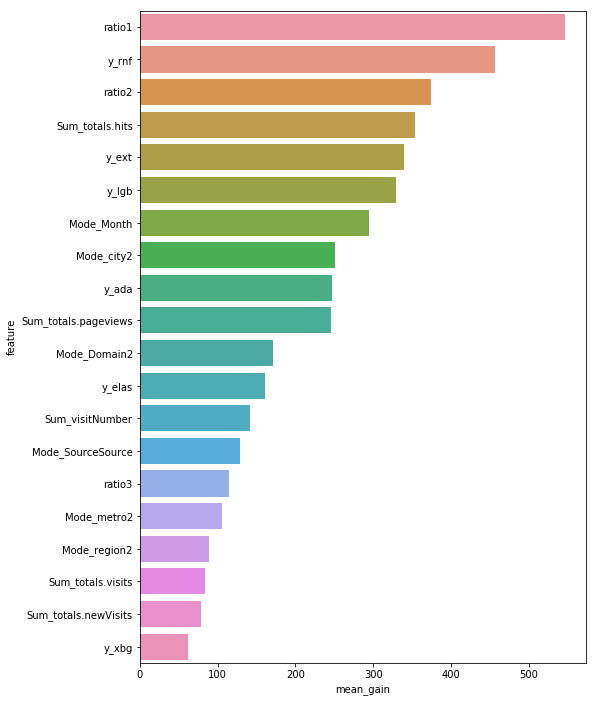

In [77]:
import warnings
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
warnings.simplefilter('ignore', FutureWarning)

importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 12))
sns.barplot(x='mean_gain', y='feature', data=importances.sort_values('mean_gain', ascending=False))

In [67]:
a = model1.feature_importances_
a.shape

(75,)

In [176]:
# importances

In [69]:
select_feature = importances.sort_values('mean_gain', ascending=False).groupby('feature').mean()
select_feature = select_feature[select_feature['mean_gain'] > 50]
select_feature = select_feature.index.values.tolist() + ['y_lgb']
# select_feature = np.hstack(select_feature.index.values,np.array(['y_lgb']))
select_feature

['Mode_Domain2',
 'Mode_Month',
 'Mode_SourceSource',
 'Mode_city2',
 'Mode_metro2',
 'Mode_region2',
 'Sum_totals.hits',
 'Sum_totals.newVisits',
 'Sum_totals.pageviews',
 'Sum_totals.visits',
 'Sum_visitNumber',
 'ratio1',
 'ratio2',
 'ratio3',
 'y_ada',
 'y_elas',
 'y_ext',
 'y_lgb',
 'y_rnf',
 'y_xbg',
 'y_lgb']

In [114]:
# select_feature.index

Index(['Mode_Country2', 'Mode_Domain2', 'Mode_Month',
       'Mode_OperatSys2.Macintosh', 'Mode_SourceSource', 'Mode_city2',
       'Mode_device.deviceCategory.desktop', 'Mode_metro2', 'Mode_region2',
       'Sum_totals.hits', 'Sum_totals.newVisits', 'Sum_totals.pageviews',
       'Sum_totals.visits', 'Sum_visitNumber', 'ratio1', 'ratio2', 'ratio3'],
      dtype='object', name='feature')

In [45]:
importances

,feature,gain,fold,gain_log,mean_gain
0,Sum_visitNumber,210,1,5.351858,203.25
1,Mode_geoNetwork.subContinent,47,1,3.871201,52.00
2,Sum_totals.bounces,23,1,3.178054,31.00
3,Sum_totals.hits,294,1,5.686975,304.50
4,Sum_totals.newVisits,121,1,4.804021,126.50
5,Sum_totals.pageviews,583,1,6.369901,557.25
6,Sum_totals.visits,130,1,4.875197,140.25
7,Mode_Month,436,1,6.079933,430.00
8,Mode_browser2,31,1,3.465736,29.75
9,Mode_city2,301,1,5.710427,330.50


In [41]:
importances.sort_values('mean_gain', ascending=False))

SyntaxError: invalid syntax (<ipython-input-41-a36c5852260c>, line 1)

In [37]:
importances.loc[importances['mean_gain'] > 30]

,feature,gain,fold,gain_log,mean_gain
0,Sum_visitNumber,210,1,5.351858,203.25
1,Mode_geoNetwork.subContinent,47,1,3.871201,52.00
2,Sum_totals.bounces,23,1,3.178054,31.00
3,Sum_totals.hits,294,1,5.686975,304.50
4,Sum_totals.newVisits,121,1,4.804021,126.50
5,Sum_totals.pageviews,583,1,6.369901,557.25
6,Sum_totals.visits,130,1,4.875197,140.25
7,Mode_Month,436,1,6.079933,430.00
9,Mode_city2,301,1,5.710427,330.50
10,Mode_Country2,153,1,5.036953,160.00


In [27]:
np.argsort(a) 

array([34, 36, 31, 30, 29, 38, 27, 26, 39, 40, 41, 46, 20, 19, 48, 50, 35,
       53, 54, 55, 56, 57, 58, 51, 66, 62, 63, 67, 52, 64, 65, 33, 49, 24,
       61, 60, 68, 22, 23, 37, 42, 25, 44, 47, 59,  8,  2, 21, 43, 32, 14,
        1, 28, 45, 18,  4, 11, 12, 10, 13,  6,  0, 15,  3,  9,  7, 17,  5,
       16], dtype=int64)

In [24]:
list(x)[0]

'Sum_visitNumber'

In [322]:
np.argwhere(a >= 40)[:,0].shape

(20,)

In [228]:
model.feature_importances_

array([183,  50,  20, 279, 125, 555, 145, 437,  28, 334, 148, 114, 158,
       173,  31, 261, 740, 545, 103,   0,   0,  28,  15,   7,   1,   6,
         2,   0,  96,  21,   0,   1,  25,   2,   0,   0,   0,  11,   0,
         0,   0,   0,   7,  30,  33, 113,   0,  15,   0,   0,   0,   1,
         0,   0,   0,   0,   0,   0,   0,  20,   3,   6,   0,   0,   8,
         1,   0,   2,  17])

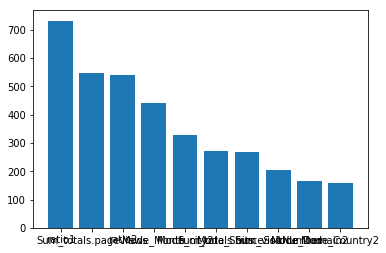

In [203]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
# a = clf.coef_ 
# a = clf.best_estimator_.feature_importances_
b = model1.feature_importances_
sort = b.argsort()[-10:][::-1]
a= b[sort]

fname = np.asarray(feature_name)[sort]
# a = a[:15]
pyplot.bar(range(len(a)), a,tick_label =fname,width =0.8)
pyplot.axis('tight')

pyplot.show()

In [204]:
fname

array(['ratio1', 'Sum_totals.pageviews', 'ratio2', 'Mode_Month',
       'Mode_city2', 'Sum_totals.hits', 'Mode_SourceSource',
       'Sum_visitNumber', 'Mode_Domain2', 'Mode_Country2'], dtype='<U61')

In [324]:
index_select = np.argwhere(a >= 40)[:,0]
x = x[:,index_select]
x_ans = x_ans[:,index_select]

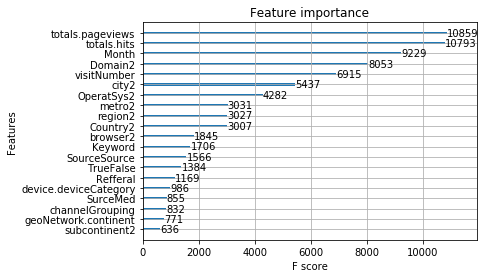

In [190]:
xgb.plot_importance(bst,max_num_features =20)

In [356]:
yc = np.copy(y)
yc[yc != 0] = 1

yc_train = np.copy(y_train)
yc_train[yc_train != 0] = 1

yc_test = np.copy(y_test)
yc_test[yc_test != 0] = 1

# yc_ans = np.copy(y_ans)
# yc_ans[yc_ans != 0] = 1
# yc_ans

In [361]:
############################################
############### Xgboost ####################
############################################
import xgboost as xgb
# dsm = xgb.DMatrix(x, label=y)
dt = xgb.DMatrix(x_test, label=yc_test,feature_names=feature_name)
dx = xgb.DMatrix(x_train, label=yc_train,feature_names=feature_name)
                  
# dt = xgb.DMatrix(x_ans_, label=yc_ans)
# dx = xgb.DMatrix(x_, label=yc)

# dsm = xgb.DMatrix(x_sm, label=y_sm)                  
evallist = [(dt, 'eval'), (dx, 'train')]

num_round = 100

param = {
  'objective': 'binary:logistic',
 'colsample_bytree': 0.9683760122352089,
 'gamma':0.8835260600913024,
#  'learning_rate': 0.1249426498504554,
#  'max_depth': 20,
 'min_child_weight': 110.95324500379702,
 'n_estimators': 19,
 'scale_pos_weight': 1,
 'seed': 42,
 'eval_metric': 'auc',
 'lambda': 70,
 'alpha': 20,
 'rate_drop':0.950292864879127905,
 'tree_method':'exact',
#  'normalize_type':'forest',
 'subsample': 0.9035691355661921
}
 
evals_result = {}
bst_c = xgb.train(param, dx, num_round, evallist, evals_result=evals_result,early_stopping_rounds=10)

[17:46:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-auc:0.938736	train-auc:0.936661
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 10 rounds.
[17:46:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-auc:0.967139	train-auc:0.965124
[17:46:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-auc:0.968085	train-auc:0.966112
[17:46:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=6
[3]	eval-auc:0.968587	train-auc:0.966598
[17:46:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prun

[17:46:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=5
[42]	eval-auc:0.989467	train-auc:0.990334
[17:46:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 10 pruned nodes, max_depth=5
[43]	eval-auc:0.989473	train-auc:0.99035
[17:46:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=6
[44]	eval-auc:0.989485	train-auc:0.990359
[17:46:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 8 pruned nodes, max_depth=4
[45]	eval-auc:0.989491	train-auc:0.990371
[17:46:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[46]	eval-auc:0.989497	train-auc:0.990387
[17:46:33] C:\Users\Administrator\D

[17:46:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 6 pruned nodes, max_depth=5
[85]	eval-auc:0.989647	train-auc:0.99075
[17:46:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[86]	eval-auc:0.989647	train-auc:0.99075
[17:46:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=6
[87]	eval-auc:0.989649	train-auc:0.990757
[17:46:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=5
[88]	eval-auc:0.989652	train-auc:0.990762
[17:46:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 10 pruned nodes, max_depth=3
[89]	eval-auc:0.989653	train-auc:0.990765
[17:46:44] C:\Users\Administrator\Des

In [362]:
treee = bst_c.best_ntree_limit
# treee = 20
# dt = xgb.DMatrix(x_test, label=yc_test,feature_names=feature_name)
yc_pre = np.array(bst_c.predict(dt, ntree_limit=treee))
# yc_pre = bst_c.predict(dt)
# yc_pre

from sklearn.metrics import precision_score,precision_recall_fscore_support
# fpr, tpr, thresholds = roc_curve(yc_test, yc_pre, pos_label=1)
thresholds = np.arange(0, 1, 0.001)
for i in thresholds:
#     print(i)
    ycx_pre  = yc_pre > i
    ycx_pre = ycx_pre.astype(int)
#     print(f1_score(yc_ans, ycx_pre, average='binary',pos_label=1),i)
    print(precision_score(yc_test, ycx_pre, average='micro',pos_label=1),i)

0.014445108587368001 0.0
0.888577252593989 0.001
0.902899750180085 0.002
0.9120725857127531 0.003
0.9182950940273116 0.004
0.9226707741352093 0.005
0.9266403053013932 0.006
0.9302343402761812 0.007
0.9334222263092556 0.008
0.9361656474627186 0.009000000000000001
0.9382347081091851 0.01
0.9403114319432311 0.011
0.9417980903336551 0.012
0.9433537174122948 0.013000000000000001
0.9448403758027188 0.014
0.9461737704415528 0.015
0.9474381963921713 0.016
0.9485263690284611 0.017
0.9496681839778074 0.018000000000000002
0.9507257038637792 0.019
0.9517142550615354 0.02
0.9526261743834965 0.021
0.9534767882048216 0.022
0.9543274020261467 0.023
0.955193342222631 0.024
0.9557450917283553 0.025
0.9565267368614649 0.026000000000000002
0.9571627814305639 0.027
0.9577681732493448 0.028
0.9583582386929668 0.029
0.9588486826980551 0.03
0.9594847272671541 0.031
0.960074792710776 0.032
0.9606265422165003 0.033
0.9611016598464297 0.034
0.961592103851518 0.035
0.9620825478566064 0.036000000000000004
0.962488

0.9865204530476497 0.307
0.9865357794228087 0.308
0.9865587689855472 0.309
0.9866354008613423 0.31
0.9866354008613423 0.311
0.9866430640489218 0.312
0.9866737167992398 0.313
0.9866583904240808 0.314
0.9866277376737628 0.315
0.9866124112986038 0.316
0.9865817585482858 0.317
0.9866047481110243 0.318
0.9866047481110243 0.319
0.9866277376737628 0.32
0.9866354008613423 0.321
0.9866430640489218 0.322
0.9866354008613423 0.323
0.9866737167992398 0.324
0.9867043695495579 0.325
0.9867273591122964 0.326
0.9867350222998759 0.327
0.9867503486750349 0.328
0.9867810014253529 0.329
0.9867886646129324 0.33
0.9868346437384095 0.331
0.9868806228638864 0.332
0.9869036124266249 0.333
0.9869189388017839 0.334
0.9869572547396815 0.335
0.98698024430242 0.336
0.9870032338651585 0.337
0.987026223427897 0.338
0.9870492129906356 0.339
0.9870492129906356 0.34
0.9870568761782151 0.341
0.9871181816788511 0.342
0.9871181816788511 0.343
0.9871335080540101 0.34400000000000003
0.9871335080540101 0.34500000000000003
0.98

0.9875319938081444 0.615
0.987539656995724 0.616
0.9875243306205649 0.617
0.9875166674329854 0.618
0.9875319938081444 0.619
0.9875243306205649 0.62
0.9875090042454059 0.621
0.987539656995724 0.622
0.9875319938081444 0.623
0.987539656995724 0.624
0.987539656995724 0.625
0.9875319938081444 0.626
0.9875166674329854 0.627
0.9875243306205649 0.628
0.9875319938081444 0.629
0.9875243306205649 0.63
0.9874860146826674 0.631
0.9874860146826674 0.632
0.9874706883075084 0.633
0.9874706883075084 0.634
0.9874630251199289 0.635
0.9874630251199289 0.636
0.9874630251199289 0.637
0.9874706883075084 0.638
0.9874936778702469 0.639
0.9874936778702469 0.64
0.9874936778702469 0.641
0.9874936778702469 0.642
0.9874783514950879 0.643
0.9874783514950879 0.644
0.9874630251199289 0.645
0.9874783514950879 0.646
0.9874783514950879 0.647
0.9874783514950879 0.648
0.9874706883075084 0.649
0.9874553619323494 0.65
0.9874630251199289 0.651
0.9874400355571904 0.652
0.9874476987447699 0.653
0.9874476987447699 0.654
0.987440

0.9855625546002115 0.932
0.985554891412632 0.933
0.985554891412632 0.934
0.985554891412632 0.935
0.985554891412632 0.936
0.985554891412632 0.937
0.985554891412632 0.9380000000000001
0.985554891412632 0.9390000000000001
0.985554891412632 0.9400000000000001
0.985554891412632 0.9410000000000001
0.985554891412632 0.9420000000000001
0.985554891412632 0.9430000000000001
0.985554891412632 0.9440000000000001
0.985554891412632 0.9450000000000001
0.985554891412632 0.9460000000000001
0.985554891412632 0.9470000000000001
0.985554891412632 0.9480000000000001
0.985554891412632 0.9490000000000001
0.985554891412632 0.9500000000000001
0.985554891412632 0.9510000000000001
0.985554891412632 0.9520000000000001
0.985554891412632 0.9530000000000001
0.985554891412632 0.9540000000000001
0.985554891412632 0.9550000000000001
0.985554891412632 0.9560000000000001
0.985554891412632 0.9570000000000001
0.985554891412632 0.9580000000000001
0.985554891412632 0.9590000000000001
0.985554891412632 0.96
0.985554891412632 

In [363]:
ycx_pre  = yc_pre > 0.505
ycx_pre = ycx_pre.astype(int)

In [258]:
1- ycx_pre.sum()/len(ycx_pre)

0.9948346062414648

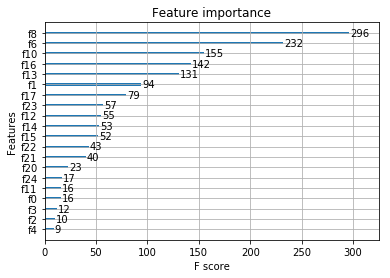

In [232]:
xgb.plot_importance(bst_c,max_num_features =20)

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN  
from imblearn.combine import SMOTEENN ,SMOTETomek

sm = SMOTEENN(random_state=42)
# sm = SMOTETomek(random_state=42)
# sm = ADASYN(random_state=42)
# sm.fit(x)
# x_sm, y_sm = sm.fit_sample(x_train, y_train)
x, yc = sm.fit_sample(x, yc)

print(x.shape,y.shape)

In [172]:
from xgboost import XGBRegressor
param = {
 'objective': 'reg:linear',
 'colsample_bytree': 0.9683760122352089,
 'gamma':0.8835260600913024,
 'learning_rate': 0.199426498504554,
 'max_depth': 20,
 'min_child_weight': 10.95324500379702,
 'n_estimators': 25,
 'scale_pos_weight': 1,
 'seed': 42,
 'eval_metric': 'rmse',
 'lambda': 150,
 'alpha': 100,
 'rate_drop':0.50292864879127905,
 'tree_method':'exact',
 'normalize_type':'forest',
 'subsample': 0.9035691355661921
  'nthread':-1,
}

clf = XGBRegressor(**param)
clf.fit(x,y)
y_clf = clf.predict(x_test)
y_clf[y_clf < 0] = 0
# y_clf[y_clf > 2952646748] = 2952646748
# y_ans = y_ans[:,0]
score1(y_test,y_clf)


0.3188442703493053

In [296]:
y_test

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's rmse: 1.7373
[40]	valid_0's rmse: 1.65721
[60]	valid_0's rmse: 1.63687
[80]	valid_0's rmse: 1.62926
[100]	valid_0's rmse: 1.62868
[120]	valid_0's rmse: 1.631
[140]	valid_0's rmse: 1.63541
[160]	valid_0's rmse: 1.64008
[180]	valid_0's rmse: 1.64315
Early stopping, best iteration is:
[88]	valid_0's rmse: 1.62743


In [317]:
y_clf = model.predict(x_test, num_iteration=model.best_iteration)
y_clf[y_clf < 0] = 0
# y_clf[y_clf > 2952646748] = 2952646748
# y_ans = y_ans[:,0]
score1(y_test,y_clf)

1.627431954710102

In [318]:
y_clf[y_clf==0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [173]:
x_cv = data.drop(['Sum_transactionRevenue'], axis=1).values
y_cv = data[['Sum_transactionRevenue']].values

In [175]:
from sklearn.model_selection import cross_val_score
# neg_mean_squared_log_error
cross_val_score(clf, x_cv, y_cv, cv=5,scoring="neg_mean_absolute_error")

array([-2608089.33516184, -2077871.22695353, -2612211.73882191,
       -2265468.29715745, -2286456.17723482])

C:\Users\EBM_IT_01\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\EBM_IT_01\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


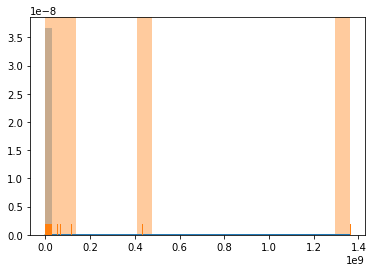

In [73]:
x_plot = y_ans[:,0]-yc_pre
x_plot = np.abs(x_plot)
sns.distplot(x_plot);
sns.distplot(x_plot, bins=20, kde=False, rug=True);

In [65]:
yc_pre

array([ 8.0695055e+06, -5.0295868e+02,  5.1632475e+05, ...,
        1.3233814e+05,  1.6087338e+05,  1.6798831e+03], dtype=float32)

In [70]:
x_plot

array([7.66657810e+05, 5.02958679e+02, 1.69351520e+05, ...,
       1.32338141e+05, 1.36926045e+05, 6.90217694e+03])

In [84]:
n = 300000
np.argwhere(x_plot > n).shape
np.argwhere(x_plot > n)

array([[   0],
       [   4],
       [   5],
       ...,
       [9924],
       [9930],
       [9940]], dtype=int64)

In [88]:
x_plot[:,np.argwhere(x_plot < n)[:,0]]

IndexError: too many indices for array

In [83]:
x

array([[2.75606782e-03, 5.07341902e-03, 3.05088435e-03, ...,
        9.16666667e-01, 0.00000000e+00, 1.00000000e+00],
       [1.67725809e-06, 2.84259875e-06, 0.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [2.50879982e-04, 3.41430258e-04, 1.94312425e-04, ...,
        9.16666667e-01, 0.00000000e+00, 1.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.16666667e-01, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

In [89]:
x_ = x[np.argwhere(x_plot < n)[:,0],:]
x_ans_ = x_ans[np.argwhere(x_plot < n)[:,0],:]

In [92]:
y_ = y[np.argwhere(x_plot < n)[:,0],:]
y_ans_ = y_ans[np.argwhere(x_plot < n)[:,0],:]

In [90]:
x_.shape

(8822, 29)

In [118]:
import xgboost as xgb
# dsm = xgb.DMatrix(x, label=y)
dt = xgb.DMatrix(x_ans, label=y_ans)
dx = xgb.DMatrix(x_, label=y_)
evallist = [(dt, 'eval'), (dx, 'train')]
num_round = 100
param = {
    'booster':'dart',
 'objective': 'reg:linear',
 'colsample_bytree': 0.9683760122352089,
 'gamma':0.8835260600913024,
#  'learning_rate': 0.199426498504554,
 'max_depth': 20,
 'min_child_weight': 10.95324500379702,
 'n_estimators': 25,
 'scale_pos_weight': 10,
 'seed': 42,
 'eval_metric': 'mae',
 'lambda': 150,
 'alpha': 100,
 'rate_drop':0.50292864879127905,
 'tree_method':'exact',
 'normalize_type':'forest',
 'subsample': 0.9035691355661921
}
evals_result = {}
bst = xgb.train(param, dx, num_round, evallist, evals_result=evals_result,early_stopping_rounds=50)

[16:37:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3756 extra nodes, 0 pruned nodes, max_depth=20
[16:37:29] C:\Users\Administrator\Desktop\xgboost\src\gbm\gbtree.cc:494: drop 0 trees, weight = 1
[0]	eval-mae:1.44346e+06	train-mae:139852
Multiple eval metrics have been passed: 'train-mae' will be used for early stopping.

Will train until train-mae hasn't improved in 50 rounds.
[16:37:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4654 extra nodes, 0 pruned nodes, max_depth=20
[16:37:29] C:\Users\Administrator\Desktop\xgboost\src\gbm\gbtree.cc:494: drop 0 trees, weight = 1
[1]	eval-mae:1.13133e+06	train-mae:183636
[16:37:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4482 extra nodes, 0 pruned nodes, max_depth=20
[16:37:29] C:\Users\Administrator\Desktop\xgboost\src\gbm\gbtree.cc:494: drop 1 trees, weight = 0.769231
[2]	eval-m

[26]	eval-mae:1.11854e+06	train-mae:101324
[16:37:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4410 extra nodes, 0 pruned nodes, max_depth=20
[16:37:32] C:\Users\Administrator\Desktop\xgboost\src\gbm\gbtree.cc:494: drop 13 trees, weight = 0.769231
[27]	eval-mae:1.18443e+06	train-mae:112135
[16:37:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4314 extra nodes, 0 pruned nodes, max_depth=20
[16:37:32] C:\Users\Administrator\Desktop\xgboost\src\gbm\gbtree.cc:494: drop 15 trees, weight = 0.769231
[28]	eval-mae:1.17851e+06	train-mae:120984
[16:37:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4564 extra nodes, 0 pruned nodes, max_depth=20
[16:37:32] C:\Users\Administrator\Desktop\xgboost\src\gbm\gbtree.cc:494: drop 10 trees, weight = 0.769231
[29]	eval-mae:1.27472e+06	train-mae:143222
[16:37:32] C:\Users\Administrator\Desktop\xgboos

[16:37:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4016 extra nodes, 0 pruned nodes, max_depth=20
[16:37:38] C:\Users\Administrator\Desktop\xgboost\src\gbm\gbtree.cc:494: drop 29 trees, weight = 0.769231
[54]	eval-mae:1.10875e+06	train-mae:103951
[16:37:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4710 extra nodes, 0 pruned nodes, max_depth=20
[16:37:38] C:\Users\Administrator\Desktop\xgboost\src\gbm\gbtree.cc:494: drop 20 trees, weight = 0.769231
[55]	eval-mae:1.13232e+06	train-mae:120567
[16:37:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4360 extra nodes, 0 pruned nodes, max_depth=20
[16:37:38] C:\Users\Administrator\Desktop\xgboost\src\gbm\gbtree.cc:494: drop 25 trees, weight = 0.769231
[56]	eval-mae:1.15804e+06	train-mae:139301
[16:37:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

In [114]:
treee = bst.best_ntree_limit
# treee = 20
# yc_pre = np.array(bst.predict(dt, ntree_limit=treee))
yc_pre = bst.predict(dt)
score1(y_ans,yc_pre)

1497023.198957567

In [45]:
submission = pd.read_csv('google_data/sample_submission.csv', delimiter = ',')
submission

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.0
1,0000049363351866189,0.0
2,0000053049821714864,0.0
3,0000059488412965267,0.0
4,0000085840370633780,0.0
5,0000091131414287111,0.0
6,0000117255350596610,0.0
7,0000118334805178127,0.0
8,0000130646294093000,0.0
9,0000150005271820273,0.0


In [326]:
import os # it's a operational system library, to set some informations
import random # random is to generate random values

import pandas as pd # to manipulate data frames 
import numpy as np # to work with matrix
from scipy.stats import kurtosis, skew # it's to explore some statistics of numerical values

import matplotlib.pyplot as plt # to graphics plot
import seaborn as sns # a good library to graphic plots
# import squarify # to better understand proportion of categorys - it's a treemap layout algorithm

# Importing librarys to use on interactive graphs
# from plotly.offline import init_notebook_mode, iplot, plot 
# import plotly.graph_objs as go 

import json # to convert json in df
from pandas.io.json import json_normalize # to normalize the json file

columns = ['device', 'geoNetwork', 'totals', 'trafficSource'] # Columns that have json format

dir_path = "google_data/" # you can change to your local 

# p is a fractional number to skiprows and read just a random sample of the our dataset. 
p = 0.7 # *** In this case we will use 50% of data set *** #

#Code to transform the json format columns in table
def json_read(df):
    #joining the [ path + df received]
    data_frame = dir_path + df
    
    #Importing the dataset
    df = pd.read_csv(data_frame, 
                     converters={column: json.loads for column in columns}, # loading the json columns properly
                     dtype={'fullVisitorId': 'str'}, # transforming this column to string
                     skiprows=lambda i: i>0 and random.random() > p)# Number of rows that will be imported randomly
    
    for column in columns: #loop to finally transform the columns in data frame
        #It will normalize and set the json to a table
        column_as_df = json_normalize(df[column]) 
        # here will be set the name using the category and subcategory of json columns
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns] 
        # after extracting the values, let drop the original columns
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
        
    # Printing the shape of dataframes that was imported     
    print(f"Loaded {os.path.basename(data_frame)}. Shape: {df.shape}")
    return df # returning the df after importing and transforming to_csv

In [328]:
df_test = json_read("train.csv") 

Loaded train.csv. Shape: (632669, 55)


In [329]:
df_test.to_csv("google_data/train_json_decode.csv")

In [205]:
list(df_test)

['channelGrouping',
 'date',
 'fullVisitorId',
 'sessionId',
 'socialEngagementType',
 'visitId',
 'visitNumber',
 'visitStartTime',
 'device.browser',
 'device.browserSize',
 'device.browserVersion',
 'device.deviceCategory',
 'device.flashVersion',
 'device.isMobile',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystem',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.city',
 'geoNetwork.cityId',
 'geoNetwork.continent',
 'geoNetwork.country',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.networkLocation',
 'geoNetwork.region',
 'geoNetwork.subContinent',
 'totals.bounces',
 'totals.hits',
 'totals.newVisits',
 'totals.pageviews',
 'totals.visits',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.adNetworkType

In [120]:
test = data_ans[['fullVisitorId','visitNumber']]

In [122]:
submission.join(test.set_index('fullVisitorId'),on='fullVisitorId').groupby("fullVisitorId").agg({"visitNumber" : "sum"})

,visitNumber
fullVisitorId,
0000000259678714014,0.0
0000049363351866189,0.0
0000053049821714864,0.0
0000059488412965267,0.0
0000085840370633780,0.0
0000091131414287111,0.0
0000117255350596610,0.0
0000118334805178127,0.0
0000130646294093000,0.0


In [239]:
estimator = RandomForestRegressor()
params = {
    "max_depth": [1, 2, 3,5,10, None],
    "max_features": st.randint(1, 27),
#     "max_features": ["log2"],
    "min_samples_split": st.randint(2, 10),
#     "min_samples_leaf": st.randint(1, n_features),
#     "bootstrap": [True, False],
    "criterion": ["mse"],
    'oob_score': [True, False],
    'random_state': [42],
    'warm_start' : [True],
}
rnf = RandomizedSearchCV(estimator, params, cv=5,n_jobs=-1, n_iter=10, scoring = 'neg_mean_squared_error')

In [240]:

k=1
splits=5
avg_score=0

lgb_params = {"objective" : "regression", "metric" : "rmse",
              "num_leaves" : 50, "learning_rate" : 0.032, 
              "bagging_fraction" : 0.75, "feature_fraction" : 0.8, "bagging_frequency" : 9, 'use_best_model':True}

y_kf = np.copy(y)
y_kf[y_kf != 0] = 1

skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=200)
skf.get_n_splits(x)
print('\nStarting KFold iterations...')
importances = pd.DataFrame()
for train_index,test_index in skf.split(x,y_kf):

    lgb = LGBMRegressor(**lgb_params)
    xgb = XGBRegressor(nthread=-1)
    models = [('lgb',lgb),('rnf',rnf)]
   
    df_X=x[train_index,:]
    df_y=y[train_index]
    val_X=x[test_index,:]
    val_y=y[test_index]
    kk = 1
    models = [('lgb',lgb),('rnf',rnf)]
    for name,model in models:
        model.fit(df_X,df_y)
        preds_x=pd.Series(model.predict(val_X))
        acc= score1(val_y,preds_x)
        print('Iteration:',k,'  rmse:',acc,'  model:',name)
    
        if kk==1:
#             score=acc
            model1=model
            preds_stack=pd.Series(model.predict(val_X))
#             sv = preds.copy()

        else:
            preds1=pd.Series(model.predict(val_X))
            preds_stack=preds_stack+preds1
        
        kk = kk+1
    preds_stack=preds_stack/len(models)
    acc= score1(val_y,preds_stack)
    print('Iteration:',k,' (All models)   rmse:',acc)
#     imp_df = pd.DataFrame()
#     imp_df['feature'] = np.asarray(feature_name)
#     imp_df['gain'] = model.feature_importances_
    
#     imp_df['fold'] = k
#     importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
#     avg_score=avg_score+acc        
    k=k+1
# print('\n Best score:',score,' Avg Score:',avg_score/splits)
# preds=preds/splits


Starting KFold iterations...
Iteration: 1   rmse: 1.6168445813140997   model: lgb


C:\Users\EBM_IT_01\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Iteration: 1   rmse: 1.633474498512408   model: rnf
Iteration: 1  (All models)   rmse: 1.6191733549810883
Iteration: 2   rmse: 1.6168166837952265   model: lgb


C:\Users\EBM_IT_01\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Iteration: 2   rmse: 1.6412719074489954   model: rnf
Iteration: 2  (All models)   rmse: 1.6224415976771276
Iteration: 3   rmse: 1.609027513737331   model: lgb


C:\Users\EBM_IT_01\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Iteration: 3   rmse: 1.6693029432615665   model: rnf
Iteration: 3  (All models)   rmse: 1.6284659444338523
Iteration: 4   rmse: 1.6226411514181984   model: lgb
Iteration: 4   rmse: 1.6481481989311957   model: rnf
Iteration: 4  (All models)   rmse: 1.6291505385621872
Iteration: 5   rmse: 1.6275881423381688   model: lgb
Iteration: 5   rmse: 1.6818418479801116   model: rnf
Iteration: 5  (All models)   rmse: 1.6453760243835989


C:\Users\EBM_IT_01\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [25]:
from sklearn.model_selection import StratifiedKFold
from lightgbm.sklearn import LGBMRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV , GridSearchCV

k=1
splits=5


lgb_params = {"objective" : "regression", "metric" : "rmse",
              "num_leaves" : 50, "learning_rate" : 0.032, 
              "bagging_fraction" : 0.75, "feature_fraction" : 0.8, "bagging_frequency" : 9, 'use_best_model':True}


y_kf = np.copy(y)
y_kf[y_kf != 0] = 1

x_f = x.values
skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=200)
skf.get_n_splits(x_f)
print('\nStarting KFold iterations...')
importances = pd.DataFrame()

x_stack = pd.DataFrame({'ini':np.zeros(x.shape[0])})
x_ans_stack = pd.DataFrame({'ini':np.zeros(x_ans.shape[0])})

avg_score= np.zeros(6)
avg_score_all = 0
kk = 1
for train_index,test_index in skf.split(x_f,y_kf):

    lgb = LGBMRegressor(**lgb_params)
#     xgb = XGBRegressor(nthread=-1)

    
    df_X=x_f[train_index,:]
    df_y=y[train_index]
    val_X=x_f[test_index,:]
    val_y=y[test_index]
    
    modelq = regressor.get_regressor(n_jobs = -1,n_iter = 5,n_iter_nt = 2,n_components = 25,cv = 5,
                  seed=42,n_features= 40,is_pca = False,scoring = 'neg_mean_absolute_error')
#     models = [('lgb',lgb),('xgb',xgb),('rnf',rnf)]
    models = [('lgb',lgb)] + modelq
    for n,(name,model) in enumerate(models,0):
        model.fit(df_X,df_y)
        preds_x=pd.Series(model.predict(val_X))
        acc = score1(val_y,preds_x)
        print('Iteration:',k,'  rmse:',acc,'  model:',name)
        if k==1:
            x_stack['y_'+name] = 0
            x_ans_stack['y_'+name] = 0
            
        if kk == 1:
            kk = kk+1;
            x_stack = x_stack.drop(['ini'],axis=1)
            x_ans_stack = x_ans_stack.drop(['ini'],axis=1)
        x_stack['y_'+name][test_index] = preds_x 
        preds1=pd.Series(model.predict(x_ans.values))
        
        x_ans_stack['y_'+name] += (preds1/splits)
        avg_score[n]=avg_score[n]+acc
    
    val_mean = np.mean(x_stack.values[test_index,:], axis=1)
    avg_score_all += score1(val_y,val_mean)/splits
    print('Iteration:',k,' (All models)   rmse:',score1(val_y,val_mean))
    k=k+1
print(' Avg Score:',avg_score/splits,"  All models:",avg_score_all)
# print('\n Best score:',score,' Avg Score:',avg_score/splits)
# preds=preds/splits
# x_ans_stack = x_ans.copy()
# x_ans_stack['y_lgb'] = 0
# x_ans_stack['y_lgb'] = preds


Starting KFold iterations...
Iteration: 1   rmse: 1.6146913344419118   model: lgb
Iteration: 1   rmse: 2.103823415463157   model: xbg


C:\Users\EBM_IT_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Iteration: 1   rmse: 1.6376556392016466   model: rnf


C:\Users\EBM_IT_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Iteration: 1   rmse: 1.9107490148554325   model: ext


C:\Users\EBM_IT_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Iteration: 1   rmse: 2.276413853849632   model: ada


C:\Users\EBM_IT_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Iteration: 1   rmse: 1.8143451956450163   model: elas


C:\Users\EBM_IT_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Iteration: 1  (All models)   rmse: 1.7126322203663067
Iteration: 2   rmse: 1.617130730483827   model: lgb
Iteration: 2   rmse: 2.1075407893217655   model: xbg
Iteration: 2   rmse: 1.6387075174774817   model: rnf
Iteration: 2   rmse: 1.645825834088968   model: ext
Iteration: 2   rmse: 2.3097790639132323   model: ada
Iteration: 2   rmse: 1.832210827558753   model: elas
Iteration: 2  (All models)   rmse: 1.6930315729410021
Iteration: 3   rmse: 1.6106447912020534   model: lgb
Iteration: 3   rmse: 2.1077026442245574   model: xbg
Iteration: 3   rmse: 1.671326994510118   model: rnf
Iteration: 3   rmse: 1.7493061055319288   model: ext
Iteration: 3   rmse: 2.2368272506551743   model: ada
Iteration: 3   rmse: 1.8490699931878691   model: elas
Iteration: 3  (All models)   rmse: 1.6985736049332991
Iteration: 4   rmse: 1.6228058433719683   model: lgb
Iteration: 4   rmse: 2.1075867647640645   model: xbg
Iteration: 4   rmse: 1.6889989690029623   model: rnf
Iteration: 4   rmse: 1.65095205257341   model

In [34]:
sv = np.mean(x_ans_stack.values[:,(0,2)],axis=1)

In [16]:
import regressor

C:\Users\EBM_IT_01\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\EBM_IT_01\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [26]:
x_stack

,y_lgb,y_xbg,y_rnf,y_ext,y_ada,y_elas
0,0.011861,5.960464e-08,0.000000,0.006006,0.571715,0.458841
1,0.134738,6.231666e-05,0.000000,0.198501,1.755899,0.831707
2,0.044002,5.960464e-08,0.000000,0.000000,0.006215,0.225099
3,0.011846,1.177400e-03,0.000000,0.000000,0.004310,-0.115079
4,0.012426,3.400141e-02,0.000000,0.600171,0.003501,0.237957
5,0.017200,1.177400e-03,0.037582,0.000000,0.499057,0.393055
6,0.012305,6.231666e-05,0.000000,0.033419,0.005982,-0.144365
7,0.012426,3.400141e-02,0.000000,0.009112,0.003501,-0.055648
8,0.012159,5.960464e-08,0.000000,0.000000,0.005345,-0.055564
9,0.012159,5.960464e-08,0.000000,0.000000,0.005345,-0.093098


In [264]:
val_y.shape

(130495,)

In [258]:
test_index.shape

(130495,)

In [268]:
score(val_y,val_mean)

TypeError: 'numpy.float64' object is not callable

In [269]:
val_y

array([0., 0., 0., ..., 0., 0., 0.])

In [270]:
val_mean

array([0.1095431 , 0.01394459, 1.03464971, ..., 0.01394459, 0.01394459,
       0.01394459])

In [272]:
avg_score

array([6.47305186])

In [284]:
model.feature_importances_.shape

(114,)

In [57]:
x_ans_stack.to_csv("google_submit/x_ans_stack.csv",index=False)

In [58]:
x_stack.to_csv("google_submit/x_stack.csv",index=False)

In [15]:
x_ans_stack = pd.read_csv('google_submit/x_ans_stack.csv', delimiter = ',')
x_stack = pd.read_csv('google_submit/x_stack.csv', delimiter = ',')

In [17]:
x_stack.shape

(521976, 6)

In [59]:
#  pd.concat([x_ans, x_ans_stack], axis=1, sort=False)
x_ans.reset_index(drop=True).join(x_ans_stack)

,Sum_visitNumber,Mode_geoNetwork.subContinent,Sum_totals.bounces,Sum_totals.hits,Sum_totals.newVisits,Sum_totals.pageviews,Sum_totals.visits,Mode_Month,Mode_browser2,Mode_city2,...,Mode_SurceMed.cpm,Mode_SurceMed.none,Mode_SurceMed.organic,Mode_SurceMed.referral,y_lgb,y_xbg,y_rnf,y_ext,y_ada,y_elas
0,1.0,0.618976,0.0,3.0,1.0,3.0,1.0,0.157007,0.338363,0.782911,...,0,0,1,0,0.012181,0.007749,0.000000,0.060911,0.005114,0.168563
1,6.0,0.003155,3.0,3.0,1.0,3.0,3.0,0.221950,0.338363,0.001474,...,0,0,0,0,0.012400,0.007749,0.000000,0.013040,0.005114,0.274146
2,0.0,0.248172,0.0,0.0,0.0,0.0,0.0,0.248172,0.248172,0.248172,...,0,1,0,0,0.064950,0.007749,0.285474,0.125534,0.005288,-0.216986
3,3.0,0.618976,1.0,1.0,0.0,1.0,1.0,0.228975,0.338363,1.235138,...,0,0,0,0,0.012181,0.007749,0.000000,0.119648,0.005114,0.175382
4,1.0,0.618976,0.0,2.0,1.0,2.0,1.0,0.221950,0.079788,0.835262,...,0,0,1,0,0.012181,0.007749,0.000000,0.059574,0.005114,0.072738
5,1.0,0.007822,1.0,1.0,1.0,1.0,1.0,0.221950,0.079788,0.161653,...,0,0,1,0,0.012181,0.007749,0.000000,0.003470,0.005114,-0.119367
6,1.0,0.618976,0.0,44.0,1.0,33.0,1.0,0.157007,0.338363,0.161653,...,0,0,0,0,4.566051,0.007749,6.252671,3.503503,8.861120,2.794468
7,1.0,0.618976,1.0,1.0,1.0,1.0,1.0,0.178509,0.338363,0.161653,...,0,0,0,0,0.012181,0.007749,0.000000,0.043564,0.005114,-0.110760
8,1.0,0.006740,0.0,3.0,1.0,2.0,1.0,0.219982,0.338363,0.161653,...,0,0,0,1,0.013639,0.007749,0.000000,0.007977,0.005114,-0.165359
9,1.0,0.007822,0.0,5.0,1.0,5.0,1.0,0.219982,0.338363,0.012260,...,0,0,1,0,0.012181,0.007749,0.000000,0.002705,0.005288,0.151714


In [41]:
x_ans_stack

,y_lgb,y_xbg,y_rnf,y_ext,y_ada,y_elas
0,0.012181,0.007749,0.000000,0.060911,0.005114,0.168563
1,0.012400,0.007749,0.000000,0.013040,0.005114,0.274146
2,0.064950,0.007749,0.285474,0.125534,0.005288,-0.216986
3,0.012181,0.007749,0.000000,0.119648,0.005114,0.175382
4,0.012181,0.007749,0.000000,0.059574,0.005114,0.072738
5,0.012181,0.007749,0.000000,0.003470,0.005114,-0.119367
6,4.566051,0.007749,6.252671,3.503503,8.861120,2.794468
7,0.012181,0.007749,0.000000,0.043564,0.005114,-0.110760
8,0.013639,0.007749,0.000000,0.007977,0.005114,-0.165359
9,0.012181,0.007749,0.000000,0.002705,0.005288,0.151714


In [42]:
preds

0          0.012181
1          0.012400
2          0.064950
3          0.012181
4          0.012181
5          0.012181
6          4.566051
7          0.012181
8          0.013639
9          0.012181
10         0.012181
11         0.012181
12         0.064950
13         0.012181
14         0.012181
15         0.012181
16         0.064950
17         0.064950
18         0.012181
19         0.012181
20         0.012181
21         0.012181
22         0.012181
23         4.104782
24         0.012181
25         0.012181
26         2.425144
27         0.012181
28         0.064950
29         0.012181
            ...    
617212     0.142480
617213     0.168617
617214     0.012181
617215     0.012181
617216     0.012181
617217     0.012181
617218     0.013439
617219     0.064950
617220     0.013639
617221     0.064950
617222     0.064950
617223     0.012181
617224     0.064950
617225     0.012181
617226     0.058427
617227     0.064950
617228     0.064950
617229     0.012181
617230     0.306887


In [45]:
preds

0         0.014950
1         0.014950
2         0.014950
3         0.014950
4         0.014950
5         0.014950
6         0.048240
7         0.039105
8         0.014950
9         0.014950
10        0.434285
11        0.014950
12        0.014950
13        0.014950
14        0.014950
15        0.014950
16        0.014950
17        0.014950
18        0.014950
19        0.039105
20        0.039105
21        0.014950
22        0.014950
23        0.024085
24        0.014950
25        0.014950
26        0.048240
27        0.014950
28        0.014950
29        0.014950
            ...   
617212    0.017985
617213    0.015936
617214    0.014950
617215    0.014950
617216    0.014950
617217    0.014950
617218    0.014950
617219    0.014950
617220    0.014950
617221    0.014950
617222    0.014950
617223    0.014950
617224    0.014950
617225    0.014950
617226    0.015435
617227    0.014950
617228    0.014950
617229    0.014950
617230    0.017985
617231    0.014950
617232    0.024085
617233    0.